In [ ]:
!pip install fastapi uvicorn nest-asyncio pyngrok tensorflow tensorflow_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 1.9 MB/s eta 0:00:00


In [ ]:
!pip install python-multipart

In [ ]:
!ngrok config add-authtoken 2wKdrzk7POFRWvygOVZT6R3l3lv_4LTPUx6eoec3MU228fYRo


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import nest_asyncio
import uvicorn
from fastapi import FastAPI, UploadFile, File
from fastapi.responses import StreamingResponse
from io import BytesIO
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import threading

# Allow multiple asyncio loops
nest_asyncio.apply()

# Load TensorFlow Hub model
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
model = hub.load(hub_handle)

# FastAPI app
app = FastAPI()

# Helper function
def load_image_into_tensor(image_bytes):
    img = Image.open(BytesIO(image_bytes)).convert('RGB')
    img = img.resize((256, 256))
    img = np.array(img) / 255.0
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.expand_dims(img, axis=0)
    return img

# Define endpoint
@app.post("/stylize/")
async def stylize(content_image: UploadFile = File(...), style_image: UploadFile = File(...)):
    content_bytes = await content_image.read()
    style_bytes = await style_image.read()

    content_tensor = load_image_into_tensor(content_bytes)
    style_tensor = load_image_into_tensor(style_bytes)

    outputs = model(content_tensor, style_tensor)
    stylized_image = outputs[0]

    img_array = tf.squeeze(stylized_image).numpy()
    img_array = np.clip(img_array * 255, 0, 255).astype(np.uint8)
    img_pil = Image.fromarray(img_array)

    buf = BytesIO()
    img_pil.save(buf, format='JPEG')
    buf.seek(0)
    return StreamingResponse(buf, media_type="image/jpeg")

# Start Uvicorn inside a thread
def start_uvicorn():
    uvicorn.run(app, host="0.0.0.0", port=8000)

thread = threading.Thread(target=start_uvicorn)
thread.start()


In [ ]:
!pip install pyngrok
from pyngrok import ngrok

# Connect ngrok to the server
public_url = ngrok.connect(8000)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://0c43-35-185-22-213.ngrok-free.app" -> "http://localhost:8000"


In [ ]:
!pip install requests
!pip install matplotlib

INFO:     35.185.22.213:0 - "POST /stylize/ HTTP/1.1" 200 OK
Stylized image saved successfully as stylized_output.jpg!


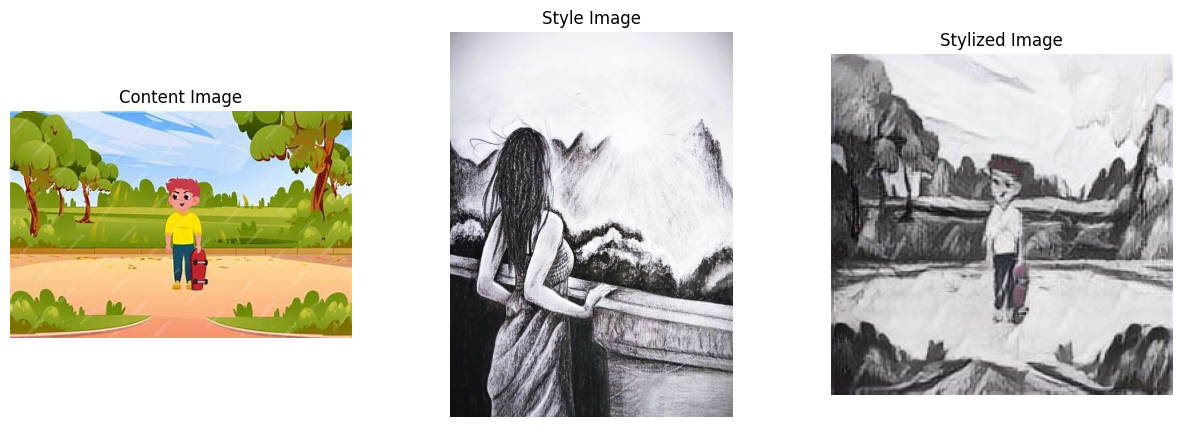

In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# API endpoint
url = "https://0c43-35-185-22-213.ngrok-free.app/stylize/"

# Load two sample images (content + style)
content_image_path = '/content/OIP.jfif'
style_image_path = '/content/R (1).jfif'

# Open files
files = {
    'content_image': open(content_image_path, 'rb'),
    'style_image': open(style_image_path, 'rb')
}

# Send POST request
response = requests.post(url, files=files)

# Save the result and display images
if response.status_code == 200:
    # Save the result
    with open('stylized_output.jpg', 'wb') as f:
        f.write(response.content)
    print("Stylized image saved successfully as stylized_output.jpg!")

    # Load the content, style, and result images for display
    content_image = Image.open(content_image_path)
    style_image = Image.open(style_image_path)
    result_image = Image.open(BytesIO(response.content))

    # Plot all images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display content image
    axes[0].imshow(content_image)
    axes[0].set_title('Content Image')
    axes[0].axis('off')

    # Display style image
    axes[1].imshow(style_image)
    axes[1].set_title('Style Image')
    axes[1].axis('off')

    # Display stylized result image
    axes[2].imshow(result_image)
    axes[2].set_title('Stylized Image')
    axes[2].axis('off')

    # Show the plot
    plt.show()

else:
    print("Error:", response.status_code, response.text)
